# FEM Module Example

In [1]:
# #Imports

# import jax
# import jax.numpy as jnp
# from jax.scipy.optimize import minimize
# import matplotlib.pyplot as plt
# from skfem.visuals.matplotlib import plot
# import skfem as fem
# from skfem.helpers import dot, grad
# import meshio
# import numpy as np
# from skfem import MeshQuad
from jaxopt import LBFGS

# FEMSystem Class 

Will move to it's own file soon

In [12]:
import numpy as np
import numpy.typing as npt

import skfem as fem
import jax.numpy as jnp

import matplotlib.pyplot as plt
from skfem.visuals.matplotlib import plot

class FEMSystem:

    # Mesh, Element, Basis
    mesh:fem.Mesh = None 
    element:fem.AbstractBasis = None 
    intorder:int = 1
    basis:fem.Basis = None

    # Size of Problem
    elements:int = 0
    quad_per_element:int = 0
    dofs:int = 0

    # Boundary Information
    boundary_condition = 0
    all_dofs = None
    boundary_dofs = None
    interior_dofs = None

    # Weights
    weights = []

    # Interpolation Matrices
    phi_val = None
    phi_grad = None

    # Miscellanous
    dofmap = None
    node_coords_global = None
    X_ref = None
    W_ref = None

    # Constructor - Preprocess Basis
    def __init__(self,mesh,element,intorder,boundary_condition=0):

        # First set mesh, element, intorder and basis
        self.mesh = mesh
        self.element = element
        self.intorder = intorder
        self.basis = fem.CellBasis(mesh, element, intorder=intorder)

        # Step 1: Get boundary information
        self.boundary_condition = boundary_condition
        self.all_dofs = jnp.arange(self.basis.N)
        self.dofs = len(self.all_dofs)
        self.boundary_dofs = self.basis.get_dofs().flatten() # Empty call automatically gets boundary DOFs
        self.interior_dofs = np.setdiff1d(self.all_dofs, self.boundary_dofs)

        # Step 2: Get Weights
        weights = jnp.array(self.basis.dx) # Only for quadrature points, not necessarily the nodes
        elements,quad_per_element = weights.shape[0],weights.shape[1]
        self.weights,self.elements,self.quad_per_element = weights,elements,quad_per_element

        # Step 3: Get Interpolation Matrices, phi_val and phi_grad
        X_ref,W_ref = self.basis.quadrature
        n_local_dofs = element.refdom.nnodes # 3 for Triangle
        val_list = []
        grad_list = []
        # Loop over local nodes to get basis functions
        for i in range(n_local_dofs):
            dfield = element.gbasis(self.basis.mapping, X_ref, i)[0]
            val_list.append(dfield.value) # (elements,quadratures), value of ith basis function, at quadrature point, in this element
            grad_list.append(dfield.grad) # (dimensions,elements,quadratures), value of the derivative in a direction, of the ith basis function, at quadrature point, in this element
        phi_val = jnp.array(np.stack(val_list)).transpose(1, 2, 0) # eth index is interpolation matrix for element e
        phi_grad = jnp.array(np.stack(grad_list)).transpose(2, 1, 3, 0) #eth index, array at dth index, is interpolation matrix for element e 
        self.phi_val,self.phi_grad = phi_val,phi_grad

        # Step 4: Get Miscellanous Things
        self.dof_map = self.basis.element_dofs.T        
        self.node_coords_global = jnp.array(mesh.doflocs.T)
        self.doflocs = self.basis.doflocs
        self.X_ref,self.W_ref = X_ref,W_ref
    
    '''
    Arguments:
    - u_global: array of values at degrees of freedom. 
    '''
    def _interpolate_values(self,u_global):
        u_local_arr = u_global[self.dof_map] # for every element, get the actual dof value at the nodes in the element
        u_quad = jnp.einsum('eqd,ed... -> eq...',self.phi_val,u_local_arr) # for every element, the interpolated values of the quadrature points. Same dims as weights!!! e for "element", q for "quadrature", d for "degree of freedom / node"
        return u_quad

    def _interpolate_grad(self,u_global):
        u_local_arr = u_global[self.dof_map] # for every element, get the actual dof value at the nodes in the element
        grad_quad = jnp.einsum('exqd,ed -> xeq',self.phi_grad,u_local_arr) # add in axis "x", for the spatial dimension, direction to take gradient in. 
        return grad_quad
    
    def _complete_arr(self,interior_vals):
        u_full = jnp.zeros(self.dofs)
        u_full = u_full.at[self.interior_dofs].set(interior_vals)
        return u_full

    # With boundary conditions
    def _get_at_nodes(self,func):

        # For each row, get only interior DOFs. 2D will have two rows for x,y, 3D will have 3 rows for x,y,z
        filtered_doflocs = self.doflocs[:,self.interior_dofs]

        # Pass each row as an argument, by "*"
        interior_vals = func(*filtered_doflocs)

        full_vals = self._complete_arr(interior_vals) # values at nodes 
        return full_vals
    
    def _get_u_from_interior(self,u_interior):
        u_final = np.ones((self.dofs))*self.boundary_condition
        u_final[self.interior_dofs] = u_interior
        return u_final
    
    '''
    Arguments:
    - vals: values at quadratures, flattened array.
    - plot_title: plot title
    '''
    def plot_at_quad_2d(self,vals,plot_title=""):
        coords = self.basis.mapping.F(self.X_ref) 
        flat_coords = coords.reshape(2, -1)

        plt.figure(figsize=(8, 8))
        sc = plt.scatter(flat_coords[0], flat_coords[1], c=vals, s=5, cmap='viridis')

        # 3. Add colorbar and formatting
        plt.colorbar(sc)
        plt.title(plot_title)
        plt.axis('equal')
        plt.show()
    
    def plot_at_quad_3d(self,vals,plot_title=""):
        coords = self.basis.mapping.F(self.X_ref) 
        flat_coords = coords.reshape(3, -1)

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        flat_vals = vals.flatten()
        sc = ax.scatter(flat_coords[0], flat_coords[1], flat_coords[2], c=flat_vals, s=5, cmap='viridis')

        # 3. Add colorbar and formatting
        plt.colorbar(sc)
        plt.title(plot_title)
        plt.show()

    def plot_at_quad_3d_sliced(self, vals, plot_title="", slice_axis='z', slice_val=0.5, tol=0.05):
        coords = self.basis.mapping.F(self.X_ref) 
        flat_coords = coords.reshape(3, -1)
        flat_vals = vals.flatten()
        
        x, y, z = flat_coords[0], flat_coords[1], flat_coords[2]
        
        # Filter points based on slice
        if slice_axis == 'z':
            mask = np.abs(z - slice_val) < tol
        elif slice_axis == 'y':
            mask = np.abs(y - slice_val) < tol
        else: # x
            mask = np.abs(x - slice_val) < tol
            
        # Apply mask
        xs, ys, zs = x[mask], y[mask], z[mask]
        vs = flat_vals[mask]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        sc = ax.scatter(xs, ys, zs, c=vs, s=10, cmap='viridis', alpha=0.8)

        plt.colorbar(sc)
        plt.title(f"{plot_title} (Slice @ {slice_axis}={slice_val:.3f})")
        ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        plt.show()


    '''
    Arguments: 
    - u_interior: array of interior points
    - plot_title: plot title
    '''
    def plot_at_interior_2d(self,u_interior,plot_title=""):
        u_final = self._get_u_from_interior(u_interior)
        ax = plot(self.basis, u_final, shading='gouraud')

        if ax.collections:
            plt.colorbar(ax.collections[0])
        
        plt.colorbar(ax.collections[0])
        plt.title(plot_title)
        plt.show()
    
    def plot_at_interior_2d_in3d(self,u_interior,plot_title=""):
        x_nodes,y_nodes = self.doflocs
        triangles = self.basis.mesh.t.T
        z_values = self._get_u_from_interior(u_interior)

        # 2. Create 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the surface
        surf = ax.plot_trisurf(x_nodes, y_nodes, z_values, 
                            triangles=triangles, 
                            cmap='viridis', 
                            edgecolor='none',
                            linewidth=0,
                            antialiased=False)
        # 3. Add labels and colorbar
        ax.set_title('3D Solution Surface')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('u(x,y)')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        plt.show()

    def plot_interior_at_quad_3d(self,u_interior,plot_title="Values at Quadratures, for a 3D Function"):
        u_global = self._get_u_from_interior(u_interior)
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad_3d(u_quad,plot_title)  
    
    def plot_interior_at_quad_3d_sliced(self,u_interior,slice_val,slice_axis="z",plot_title="Values at Quadratures, for a 3D Function Slice",tol=0.05):
        u_global = self._get_u_from_interior(u_interior)
        u_quad = self._interpolate_values(u_global)

        self.plot_at_quad_3d_sliced(u_quad,plot_title=plot_title,slice_axis=slice_axis,slice_val=slice_val,tol=tol)

    
    '''
    Arguments: 
    - func(x,y): function to plot, with boundary conditions at self.boundary_condition
    - plot_title: plot title
    '''
    def plot_values_2d(self,func,plot_title="Values at Quadratures, for a 2D Function"):
        u_global = self._get_at_nodes(func)

        # Get at quadratures and plot
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad_2d(u_quad,plot_title)

    def plot_grad_squared_2d(self,func,plot_title="Grad Squared at Quadratures, for a 2D Function"):
        u_global = self._get_at_nodes(func)

        # Get at quadratures and plot
        grad_quadx,grad_quady = self._interpolate_grad(u_global)
        laplacian_quad = grad_quadx**2 + grad_quady**2
        self.plot_at_quad_2d(laplacian_quad,plot_title)

    
    def plot_values_3d(self,func,plot_title="Values at Quadratures, for a 3D Function"):
        u_global = self._get_at_nodes(func)

        # Get at quadratures and plot
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad_3d(u_quad,plot_title) 
    
    '''
    Arguments:
    - func(x,y,z): function to plot, with boundary conditions at self.boundary_condition
    - slice_axis: "x", "y" or "z"
    - slice_val: the value along the axis to take the slice
    - tol: tolerance around the slice_val to be plotted
    '''
    def plot_values_3d_sliced(self,func,slice_val,slice_axis="z",plot_title="Values at Quadratures, for a 3D Function Slice",tol=0.05):
        u_global = self._get_at_nodes(func)

        # Get at quadratures and plot
        u_quad = self._interpolate_values(u_global)
        self.plot_at_quad_3d_sliced(u_quad,plot_title=plot_title,slice_axis=slice_axis,slice_val=slice_val,tol=tol)

    '''
    Arguments:
    - func(u,grad_u,x): where grad_u and x are multidimensional vectors. MUST return a scalar
    - u_global: array of u at degrees of freedom
    '''
    def integrate(self,func,u_global):
        u_quad = self._interpolate_values(u_global)
        grad_quad = self._interpolate_grad(u_global)
        x_quad = self._interpolate_values(self.node_coords_global) # coordinates of quadrature points

        coords_q_T = x_quad.transpose(2, 0, 1)
        L_density = func(u_quad, grad_quad, coords_q_T)
        integral_result = jnp.sum(L_density * self.weights)
        return integral_result

    '''
    Arguments:
    - func(u1,grad_u1,u2,grad_u2,x): where grad_u1/2 and x are multidimensional vectors. MUST return a scalar
    - u1_global: array of u1 at degrees of freedom
    - u2_global1: array of u2 at degrees of freedom
    '''
    def integrate_two(self,func,u1_global,u2_global):
        u1_quad = self._interpolate_values(u1_global)
        grad1_quad = self._interpolate_grad(u1_global)
        u2_quad = self._interpolate_values(u2_global)
        grad2_quad = self._interpolate_grad(u2_global)
        x_quad = self._interpolate_values(self.node_coords_global) # coordinates of quadrature points

        coords_q_T = x_quad.transpose(2, 0, 1)
        L_density = func(u1_quad,grad1_quad,u2_quad,grad2_quad,coords_q_T)
        integral_result = jnp.sum(L_density * self.weights)
        return integral_result

    def greens(self,dof_source,dof_response):
        u_global = jnp.zeros(len(self.all_dofs))
        u_global = u_global.at[dof_source].set(1)

        loc_response = self.doflocs[:dof_response] # location x,y,z of response
        func = lambda u,grad_u,x: u / (4*jnp.pi*jnp.linalg.norm(x - loc_response))

        return self.integrate(func,u_global)
    
    '''
    Arguments:
    - func(u,grad_u,x): where grad_u and x are multidimensional vectors. MUST return a scalar
    - u_global: matrix of (n,dofs). Each row is a set of u's at the degrees of freedom
    '''
    # def vec_integrate(self,func,u_global):
    #     u_quad = self._interpolate_values(u_global)
    #     grad_quad = self._interpolate_grad(u_global)
    #     x_quad = self._interpolate_values(self.node_coords_global) # coordinates of quadrature points

    #     coords_q_T = x_quad.transpose(2, 0, 1)


    #     L_density = func(u_quad, grad_quad, coords_q_T)



    #     integral_result = jnp.sum(L_density * self.weights)
    #     return integral_result 

    ''' Only intended for test purposes
    Arguments:
    - func(x): function of x (array of dimension d) you want to integrate
    '''
    def integrate_function(self,func):
        x_quad = self._interpolate_values(self.node_coords_global) # coordinates of quadrature points
        coords_q_T = x_quad.transpose(2, 0, 1)

        integrand_quad = func(coords_q_T)
        integral_result = jnp.sum(integrand_quad * self.weights)
        return integral_result
    

    '''
    Arguments:
    - u_interior: array of values only at interior dofs
    - objective(u_global): your objective function. Passes in full normalized u_global
    '''
    def apply_bc_and_norm(self,u_interior):
        u_full = jnp.ones(self.dofs) * self.boundary_condition
        u_full = u_full.at[self.interior_dofs].set(u_interior)
        u_norm = self.integrate(lambda u,a,b: u**2,u_full)
        u_full /= jnp.sqrt(u_norm)
        return u_full
    

# Defining an Optimization Problem

First create the object using the mesh and element + boundary condition

Then define objective to minimize (using the integral function from the class)

The run optimization loop

In [30]:
mesh = fem.MeshTri.init_sqsymmetric().refined(5)
element = fem.ElementTriP1()
intorder = 3 # High order to capture everything accurately

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)

# femsystem.plot_values_2d(v)
# femsystem.plot_grad_squared_2d(v)

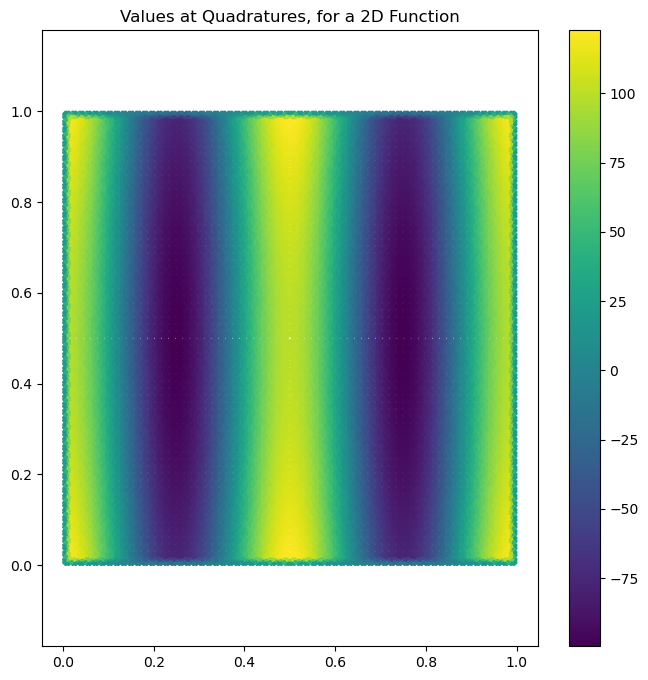

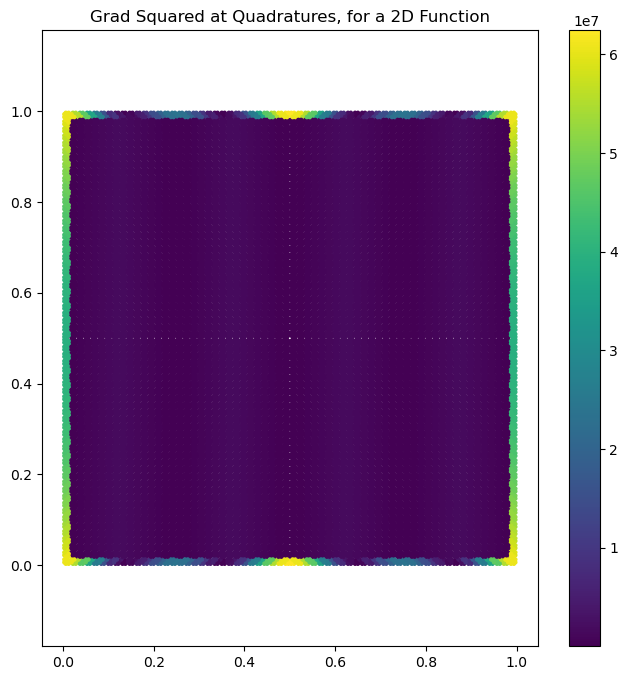

In [31]:
def v(x,y):
    return 100 * jnp.cos(4*jnp.pi*x) + 100 * (y-0.5)**2 

def lagrangian_density(u,grad_u,x):
    kinetic = 0.5 * jnp.sum(grad_u**2, axis=0) 
    
    x, y = x[0], x[1]
    f = v(x,y)
    potential = f * (u**2)
    
    return kinetic + potential

# Our objective function is to integrate the lagrangian density
def objective(u_interior):
    u_global = femsystem.apply_bc_and_norm(u_interior)
    return femsystem.integrate(lagrangian_density,u_global)

femsystem.plot_values_2d(v)
femsystem.plot_grad_squared_2d(v)


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 9.309236526489258 Objective Value:66.83650207519531  Stepsize:0.4992538094520569  Number Linesearch Iterations:2 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 6.117148399353027 Objective Value:48.173370361328125  Stepsize:0.7488807439804077  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 5.545551300048828 Objective Value:26.094676971435547  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 10.006612777709961 Objective Value:19.427955627441406  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 4.758595943450928 Objective Value:9.694738388061523  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 3.5966105461120605 Objective Value:2.0842068195343018  Stepsi

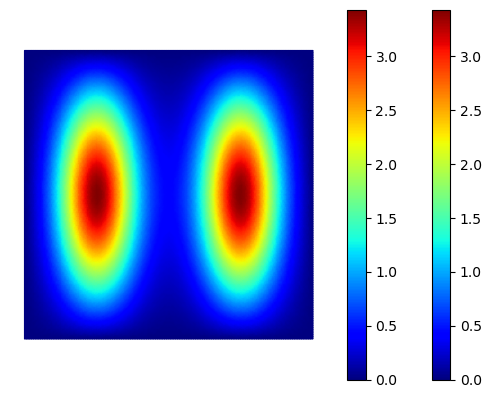

In [32]:
# Interior nodes are those NOT in boundary_dofs
u_init_interior = jnp.ones(len(femsystem.interior_dofs))
print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points

femsystem.plot_at_interior_2d(result)

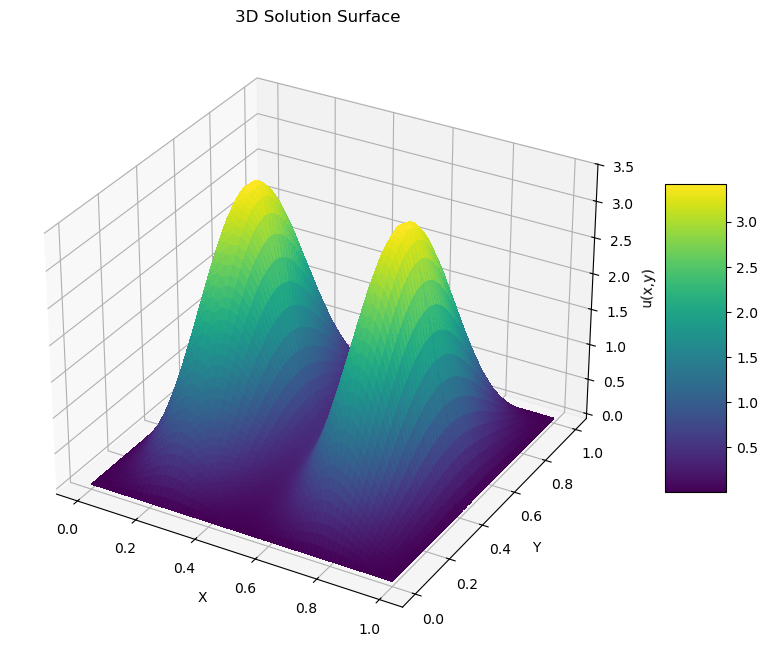

In [33]:
femsystem.plot_at_interior_2d_in3d(result)

### Next Steps

- Unit Tests
- 3D
- Non Uniform Mesh
- Two Functions
- Interaction

# 3D Optimization Problem

Transforming over 1000 elements to C_CONTIGUOUS.


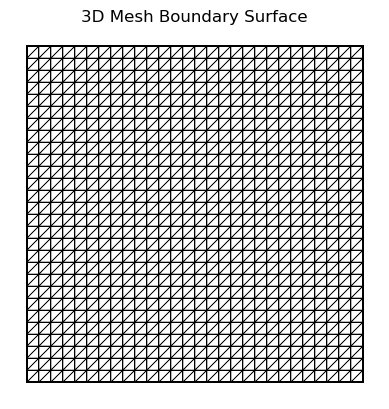

In [35]:
mesh = fem.MeshTet.init_tensor(
    np.linspace(0, 1, 8),
    np.linspace(0, 1, 8),
    np.linspace(0, 1, 8)
).refined(2)
element = fem.ElementTetP1()
intorder = 3

# 2. Initialize FEMSystem
femsystem = FEMSystem(mesh, element, intorder)

'''
Visualizing the Mesh
'''
from skfem.visuals.matplotlib import draw

# 1. Extract Boundary Surface
# Get indices of facets on the boundary
bnd_facets_indices = mesh.boundary_facets()

# Create a 2D MeshTri representing the surface of the 3D mesh
# mesh.facets contains the node indices for all faces
# We select only those on the boundary
bnd_mesh = fem.MeshTri(mesh.p, mesh.facets[:, bnd_facets_indices])

# 2. Draw the Boundary
fig = draw(bnd_mesh)
plt.title("3D Mesh Boundary Surface")
plt.show()


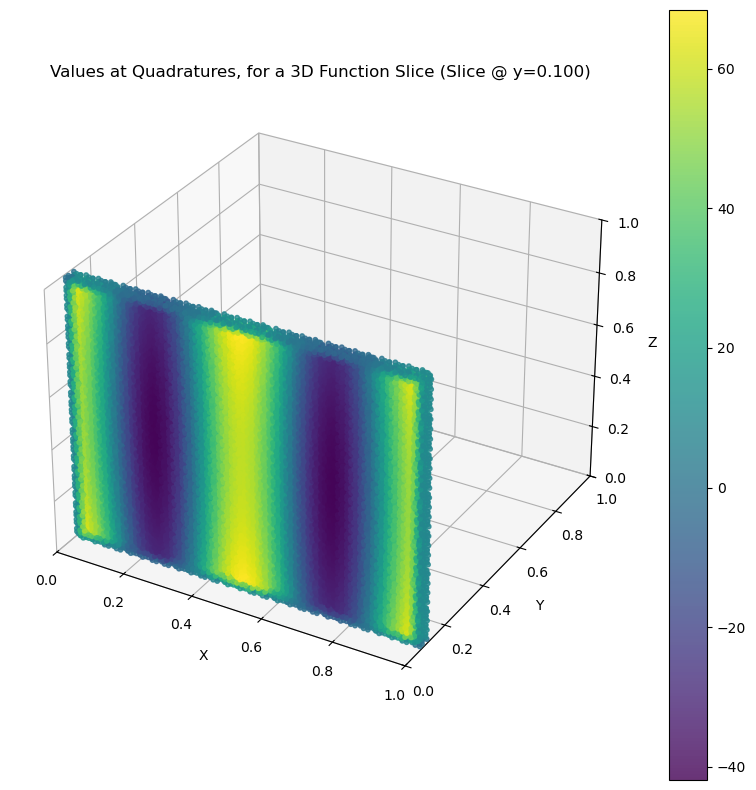

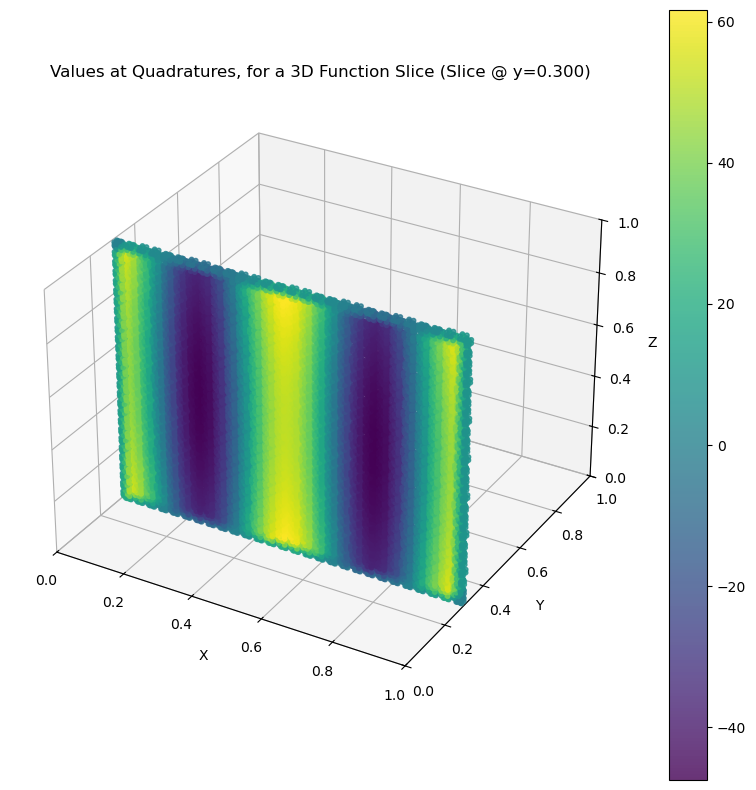

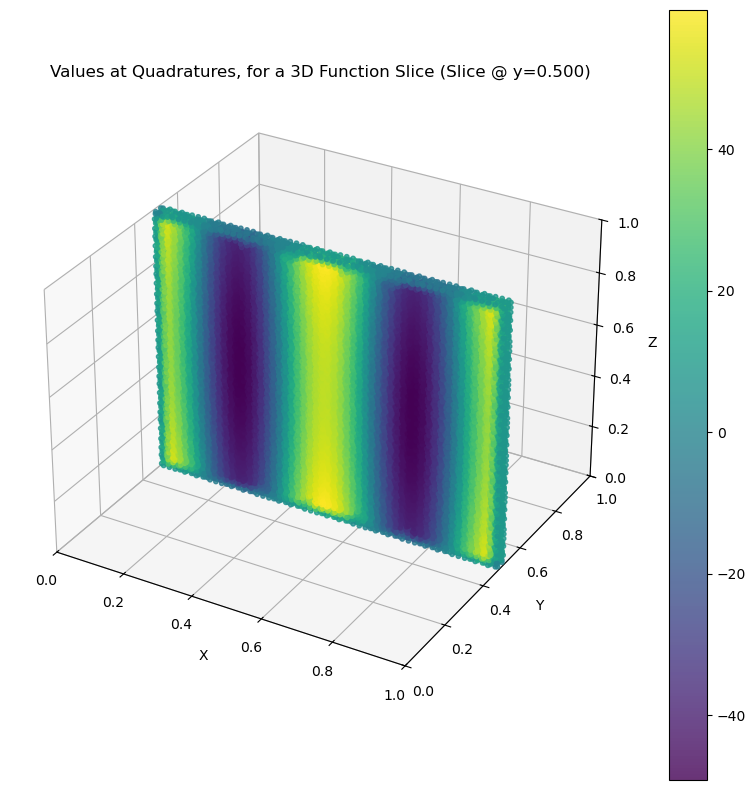

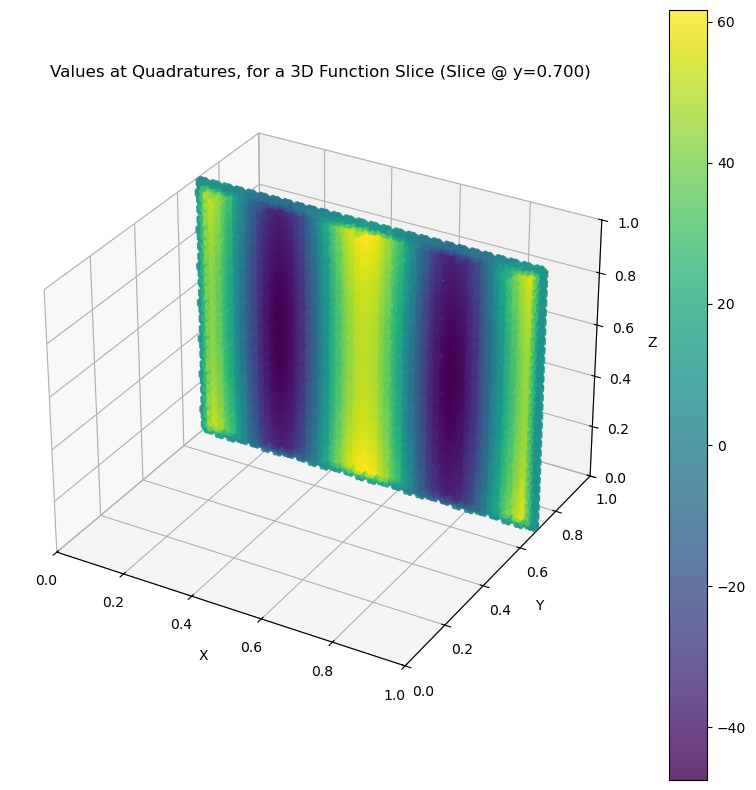

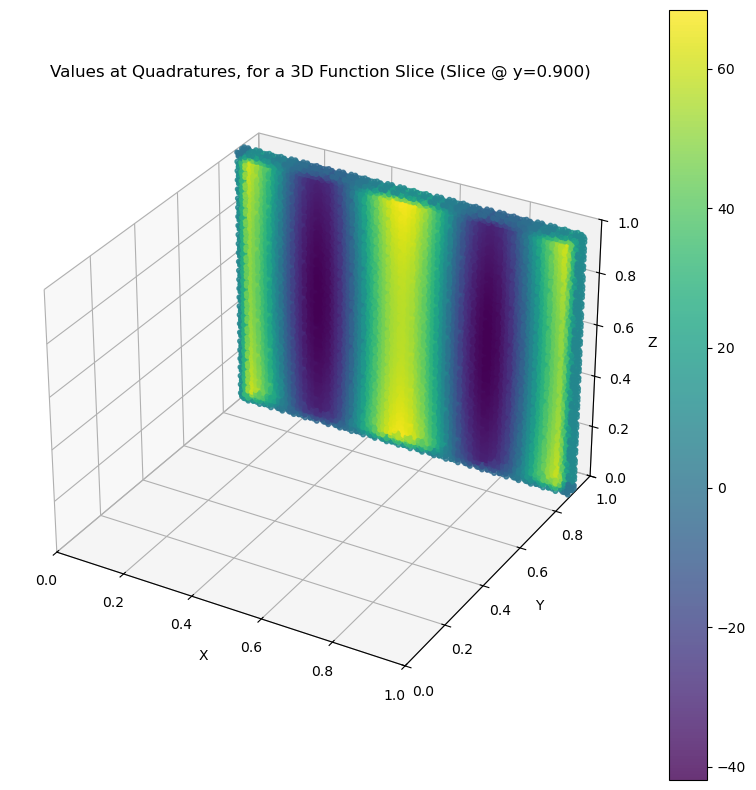

In [36]:
# 3. Define a Test Function u(x,y,z)
def v_3d(x, y, z):
    # k/2 * r^2
    r2 = jnp.cos(4*jnp.pi*x) + (y - 0.5)**2 + (z - 0.5)**2
    return 50 * r2  # Steep potential to keep wave function inside the box

def v_radial(x, y, z):
    r2 = (x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2
    return jnp.exp(-10 * r2) # Sharp decay

def lagrangian_density_3d(u,grad_u,x_vec):
    kinetic = 0.5 * jnp.sum(grad_u**2, axis=0) 
    
    x, y, z = x_vec
    f = v_3d(x,y,z)
    potential = f * (u**2)
    
    return kinetic + potential

# Our objective function is to integrate the lagrangian density
def objective_3d(u_interior):
    u_global = femsystem.apply_bc_and_norm(u_interior)
    return femsystem.integrate(lagrangian_density_3d,u_global)

# Now transform objective to enforce normalization and boundary conditions
# real_objective_3d = lambda u_interior: femsystem.apply_bc_and_norm(u_interior,objective_3d)

for i in range(5):
    femsystem.plot_values_3d_sliced(v_3d,i/5+.1,"y",tol=0.02)

In [37]:
def get_gaussian_guess():
    x_int, y_int, z_int = femsystem.doflocs[:, femsystem.interior_dofs]
    r2_int = (x_int - 0.5)**2 + (y_int - 0.5)**2 + (z_int - 0.5)**2
    u_init_gaussian = jnp.exp(-5 * r2_int) # Approximate guess
    return u_init_gaussian

# Interior nodes are those NOT in boundary_dofs
# u_init_interior = get_gaussian_guess()
u_init_interior = jnp.ones(len(femsystem.interior_dofs))
print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective_3d,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points

# femsystem.plot_at_interior_2d(result)


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 2.874434471130371 Objective Value:90.71773529052734  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 1.5670435428619385 Objective Value:41.69895935058594  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 2.3117318153381348 Objective Value:33.865028381347656  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 1.1838929653167725 Objective Value:25.990909576416016  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.762106716632843 Objective Value:19.467775344848633  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.756737232208252 Objective Value:15.865379333496094  Stepsize:1.0  Number Linesearch Ite

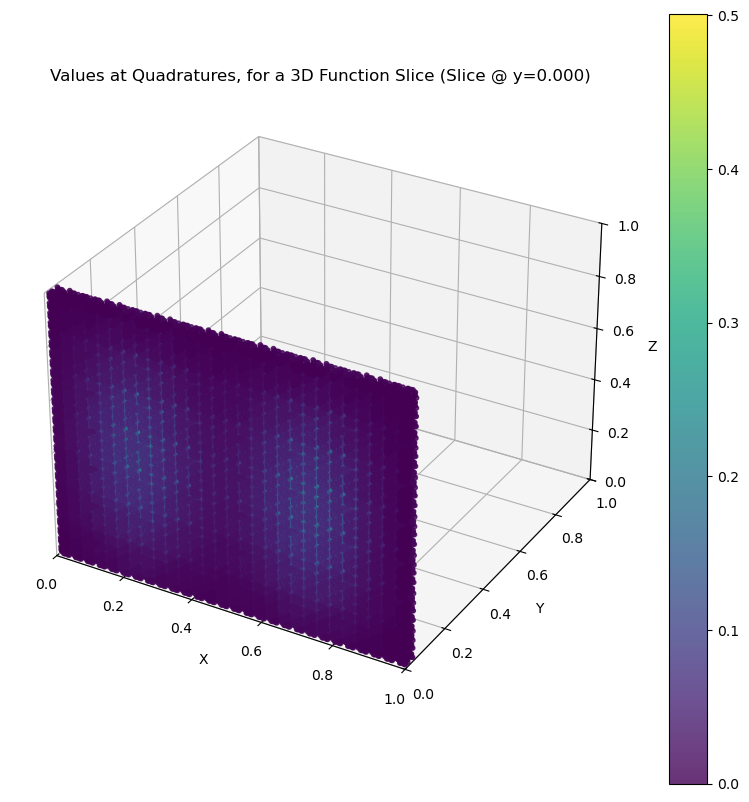

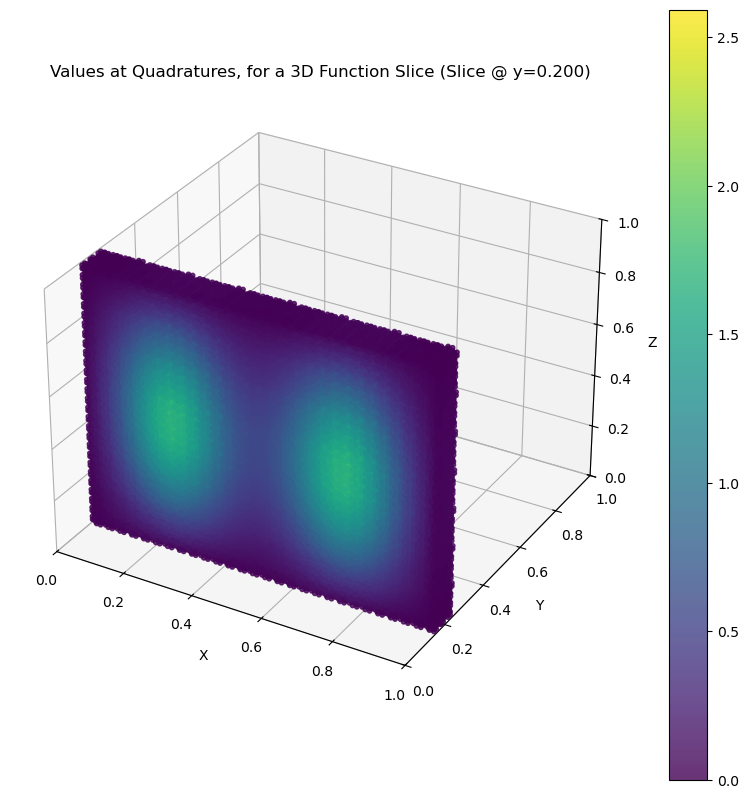

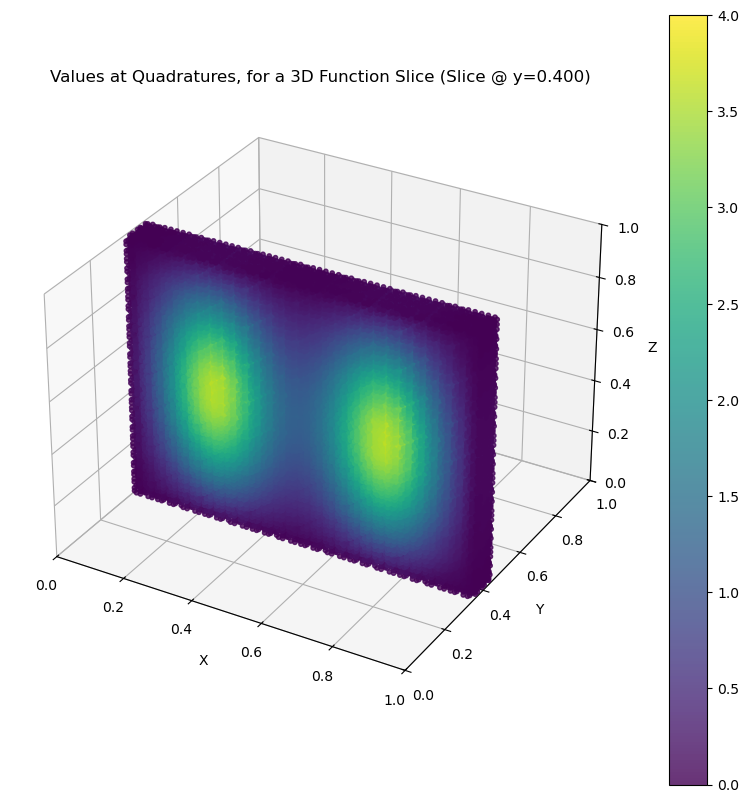

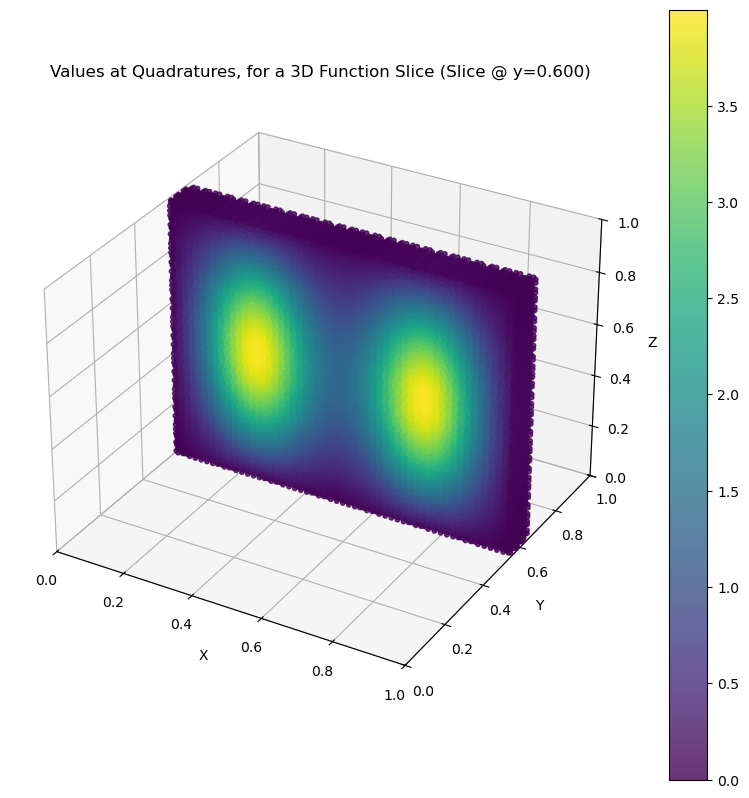

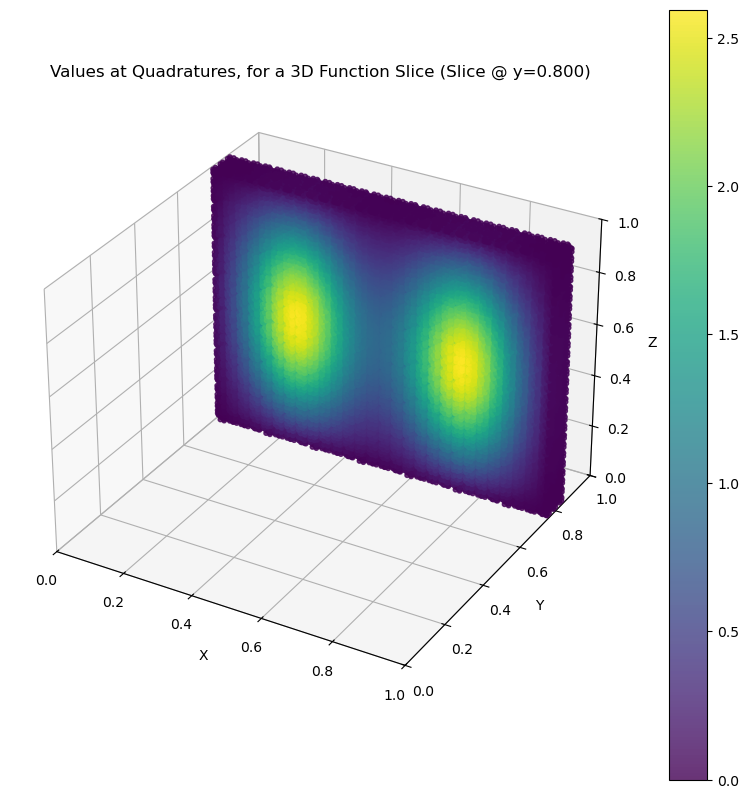

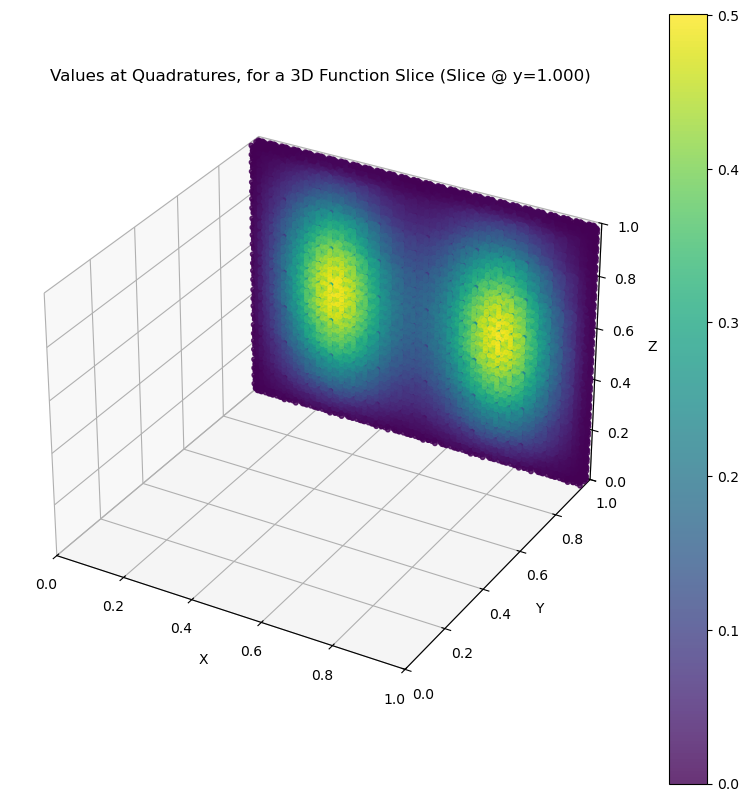

In [38]:
for i in range(6):
    femsystem.plot_interior_at_quad_3d_sliced(result,i/5,"y")

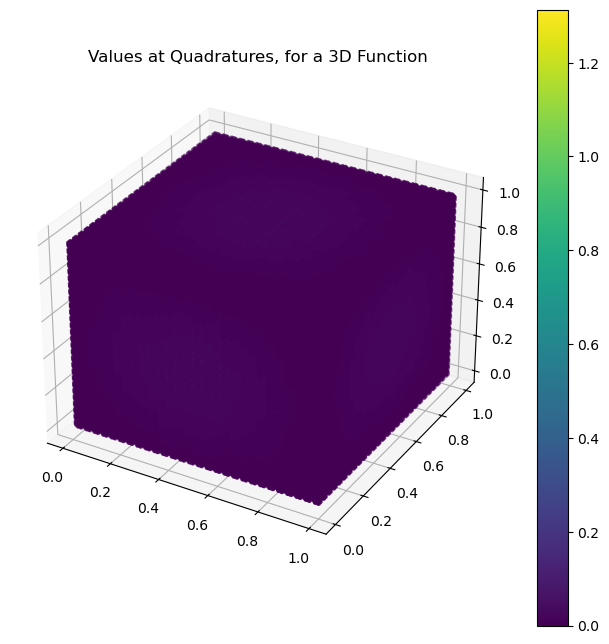

In [11]:
femsystem.plot_interior_at_quad_3d(result)

# Non-Uniform Mesh

In [39]:
from perturbedmesh import create_perturbed_mesh

perturbed_mesh = create_perturbed_mesh(refinement=1)

gmsh_mesh = fem.Mesh.load("unstructured.msh")
element = fem.ElementTetP1()
intorder = 3

# 2. Initialize FEMSystem
femsystem = FEMSystem(gmsh_mesh, element, intorder)
print(perturbed_mesh)
print(gmsh_mesh)


<skfem MeshTet1 object>
  Number of elements: 34992
  Number of vertices: 6859
  Number of nodes: 6859
<skfem MeshTet1 object>
  Number of elements: 23185
  Number of vertices: 4741
  Number of nodes: 4741
  Named subdomains [# elements]: gmsh:bounding_entities [6]


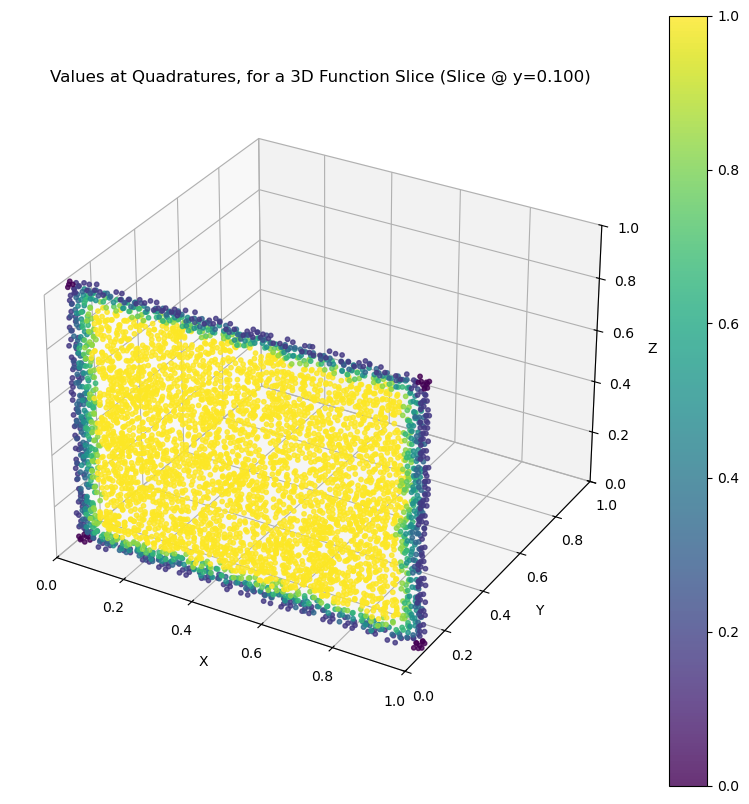

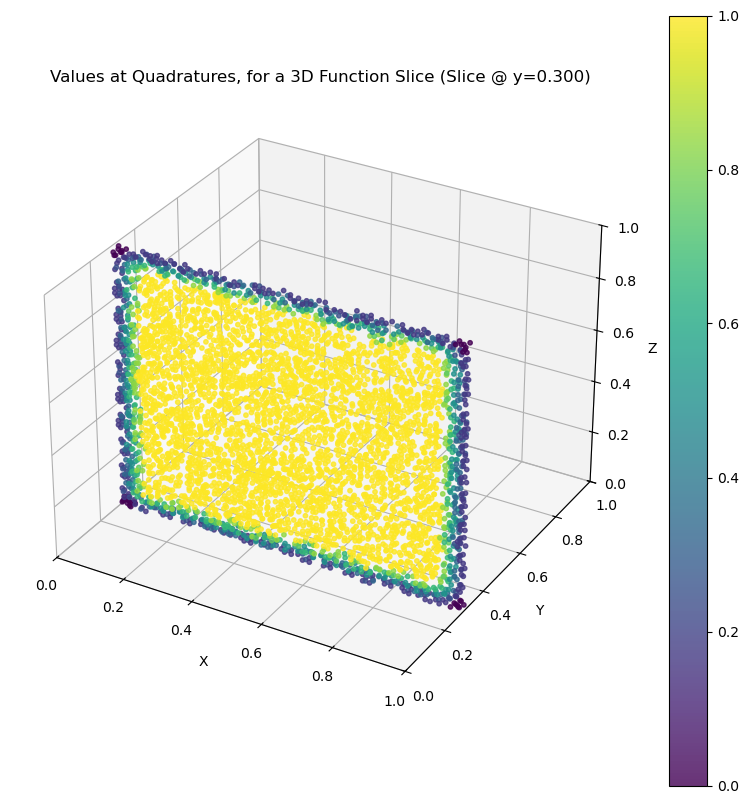

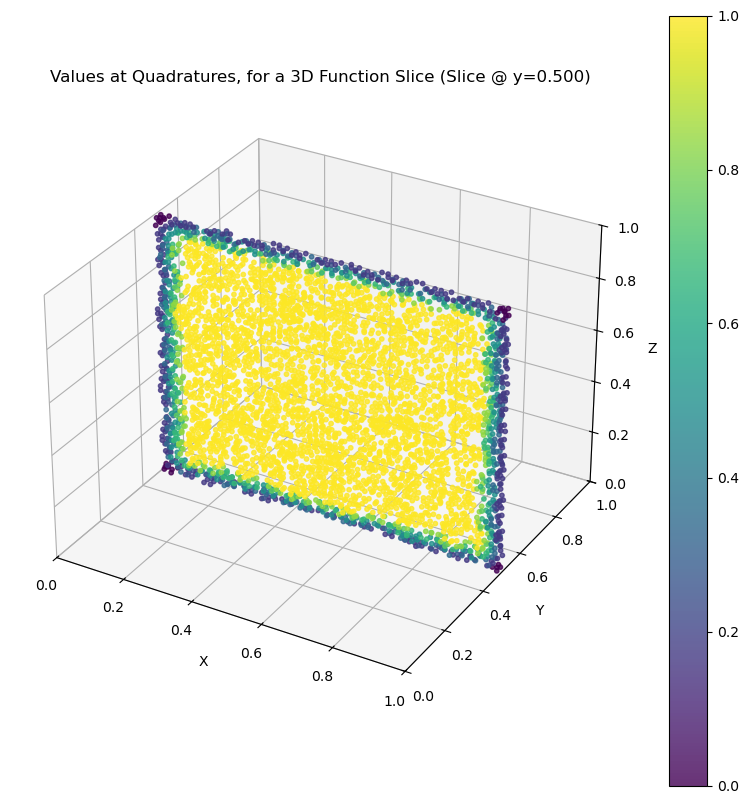

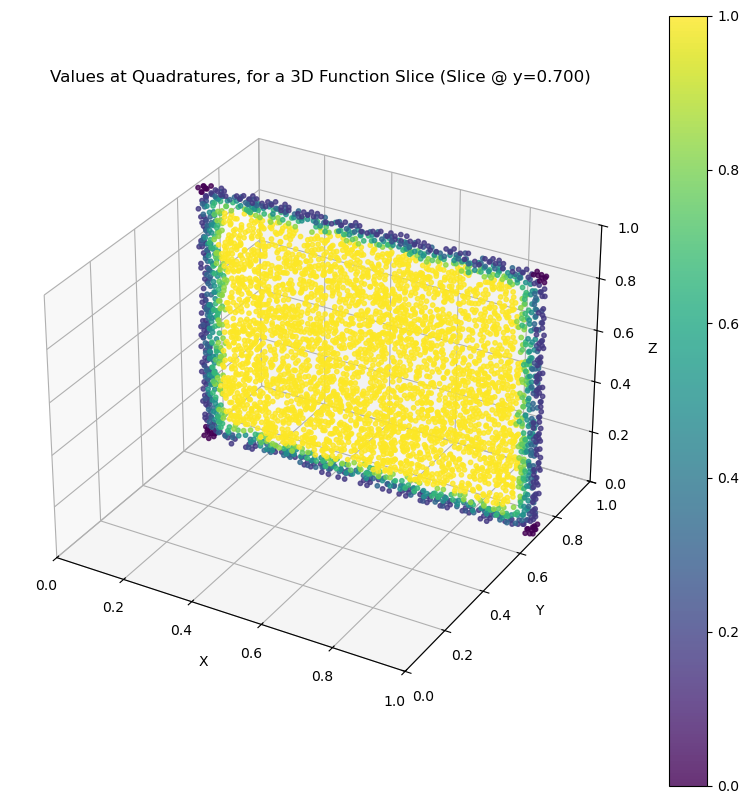

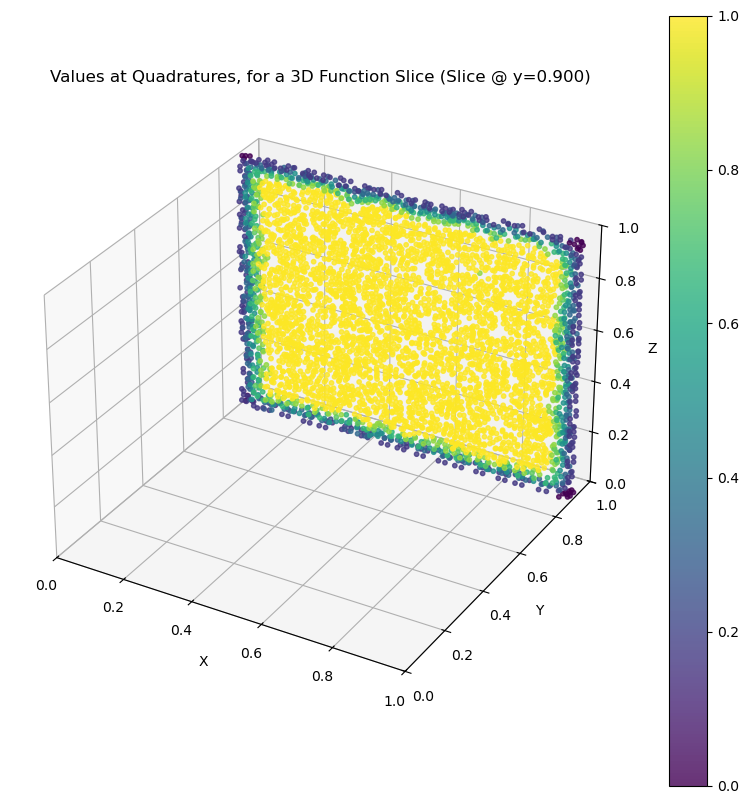

In [40]:
# 3. Define a Test Function u(x,y,z)
def v_3d(x, y, z):
    # k/2 * r^2
    r2 = jnp.cos(4*jnp.pi*x) + (y - 0.5)**2 + (z - 0.5)**2
    return 1 #* r2  # Steep potential to keep wave function inside the box

def v_radial(x, y, z):
    r2 = (x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2
    return jnp.exp(-10 * r2) # Sharp decay

def lagrangian_density_3d(u,grad_u,x_vec):
    kinetic = 0.5 * jnp.sum(grad_u**2, axis=0) 
    
    x, y, z = x_vec
    f = 1 #v_3d(x,y,z)
    potential = f * (u**2)
    
    return kinetic + potential

# Our objective function is to integrate the lagrangian density
def objective_3d(u_interior):
    u_global = femsystem.apply_bc_and_norm(u_interior)
    return femsystem.integrate(lagrangian_density_3d,u_global)

# Now transform objective to enforce normalization and boundary conditions
# real_objective_3d = lambda u_interior: femsystem.apply_bc_and_norm(u_interior,objective_3d)


for i in range(5):
    femsystem.plot_values_3d_sliced(v_3d,i/5+.1,"y",tol=0.02)

In [41]:
# Interior nodes are those NOT in boundary_dofs
u_init_interior = jnp.ones(len(femsystem.interior_dofs))
print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective_3d,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 2.8559043407440186 Objective Value:43.650333404541016  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 2.609980821609497 Objective Value:35.620906829833984  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 2.294248104095459 Objective Value:29.855159759521484  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 1.430292010307312 Objective Value:26.266990661621094  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 1.6936182975769043 Objective Value:23.970483779907227  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 1.7177913188934326 Objective Value:22.685596466064453  Stepsize:1.0  Number Linesearch I

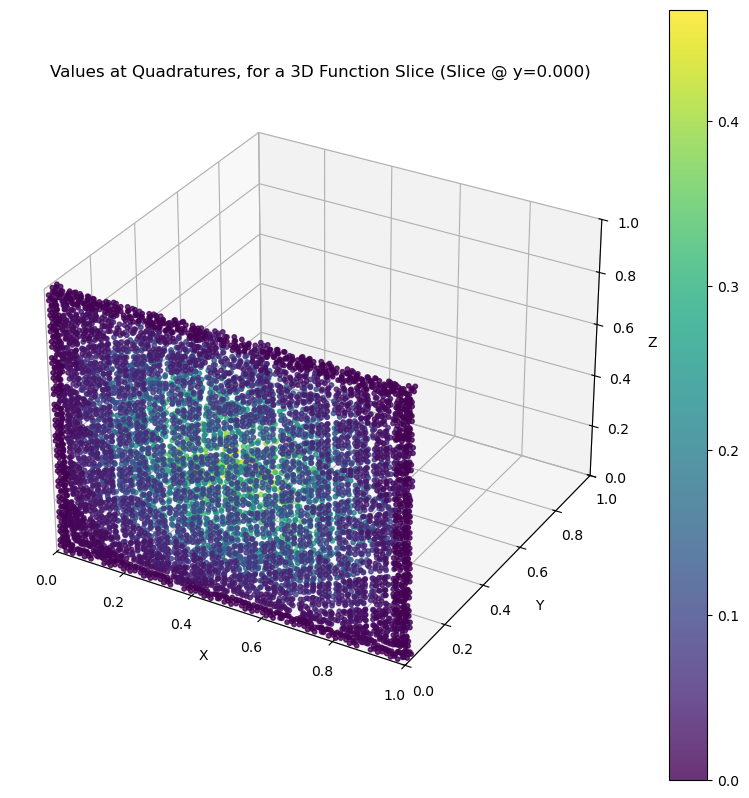

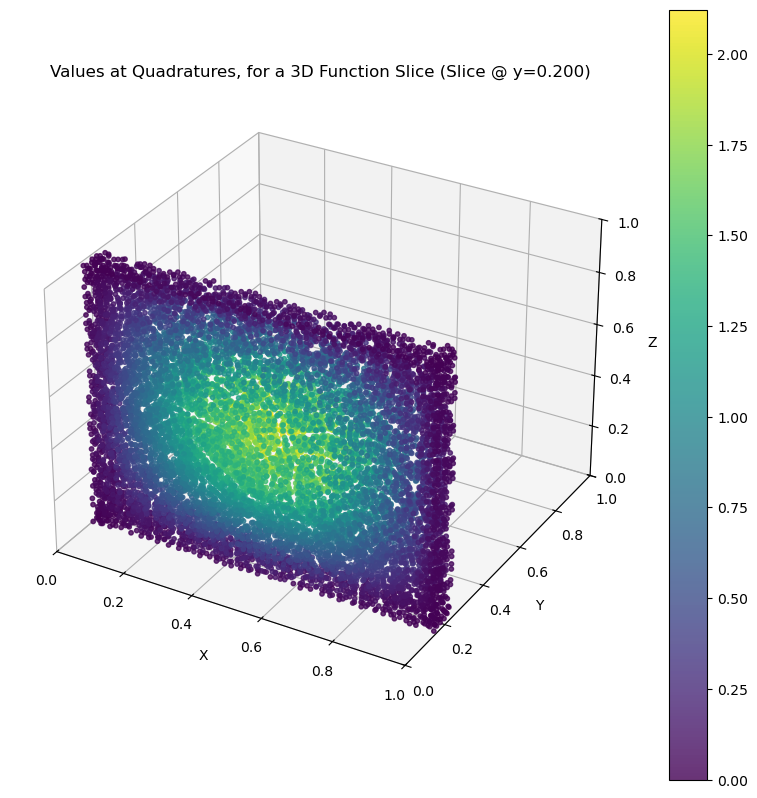

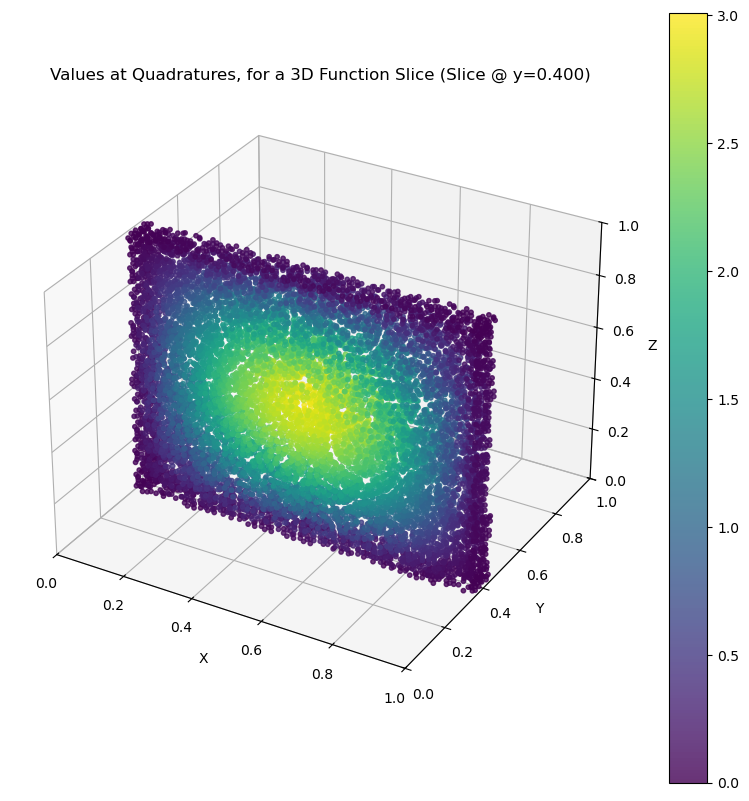

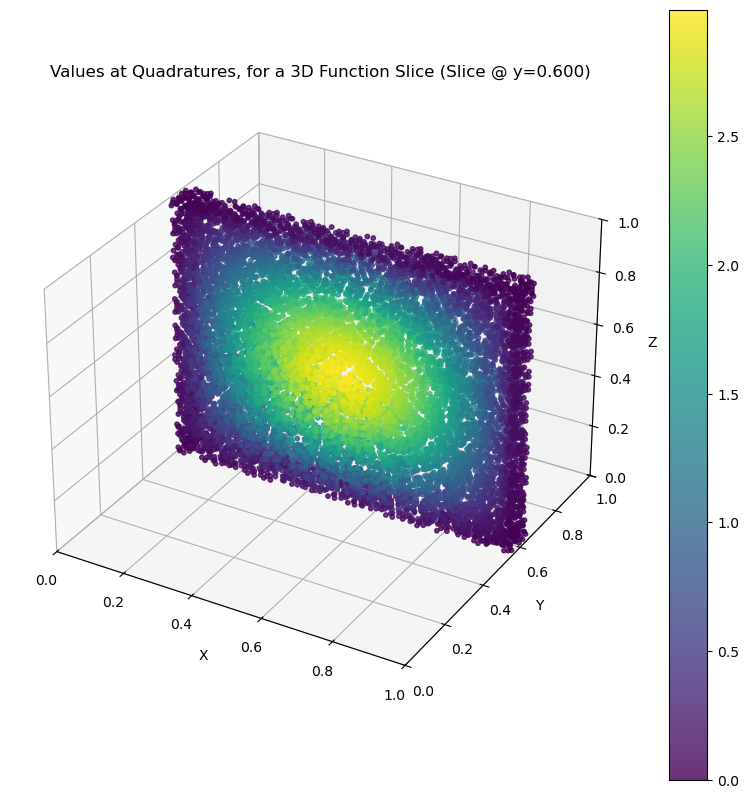

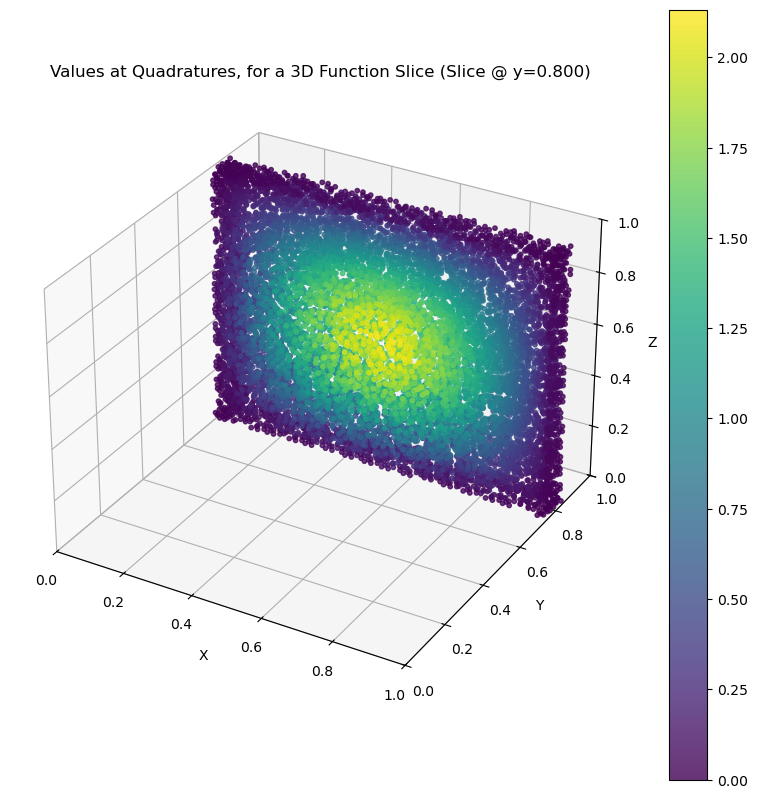

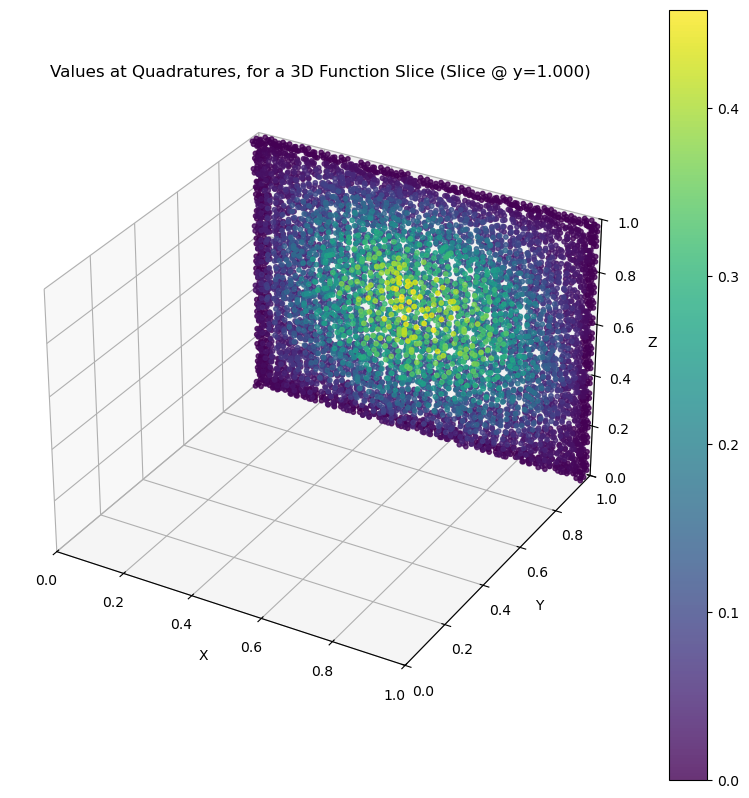

In [24]:
for i in range(6):
    femsystem.plot_interior_at_quad_3d_sliced(result,i/5,"y")

### Does NOT converge fast enough (in 500 iterations) if refinement = 2, only for non-uniform mesh. 

The shape looks generally like two peaks with boundary conditions, but too sharp of a gradient on edges. Works for the gmsh script, with min-max characteristic lengths as 0.05-0.06

# Two functions - in 2D

Lagrangian is $J[u1​,u2​]=1/2​∫_Ω​(∇u_1​∇u_2​)dV−∫_Ω​(f_1​u_1​+f_2​u_2​)dV$

In [13]:
# Step 1: Initialize FEM System
mesh = fem.MeshTri.init_sqsymmetric().refined(3)
element = fem.ElementTriP1()
intorder = 3 # High order to capture everything accurately

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)

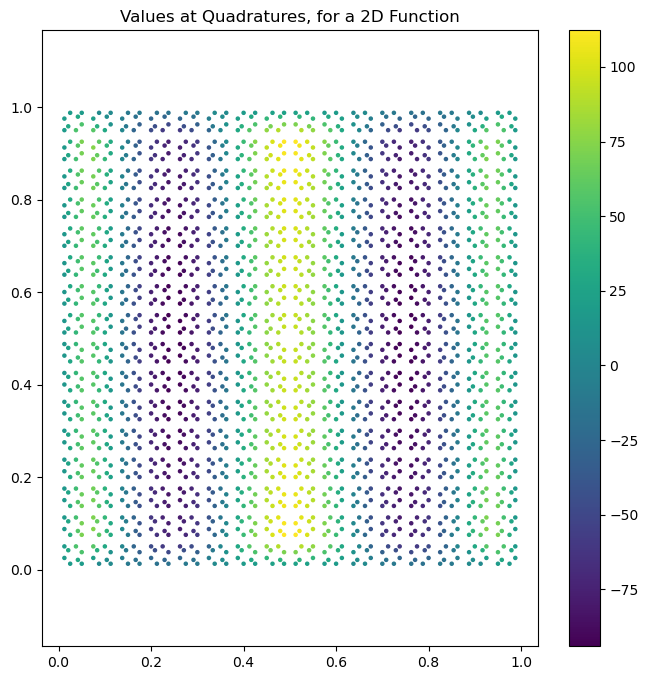

In [45]:
# Step 2: Define Optimization Objective

def kinetic(u1,grad_u1,u2,grad_u2,x):
    ke = jnp.sum(grad_u1**2 + grad_u2**2, axis=0) 
    return ke

def v1(x_vec):
    x,y = x_vec[0],x_vec[1]
    return 100 * jnp.cos(4*jnp.pi*x) + 100 * (y-0.5)**2

def v2(x_vec):
    x,y = x_vec[0],x_vec[1]
    return 100 * jnp.cos(4*jnp.pi*y) + 100 * (x-0.5)**2

def pot1(u,grad_u,x):
    return v1(x) * u**2

def pot2(u,grad_u,x):
    return v2(x) * u**2

# def interaction(u,grad_u,x):
#     return u**2

def unpack(u_interior_total):
    l_interior = len(femsystem.interior_dofs)
    u1_interior,u2_interior = u_interior_total[:l_interior],u_interior_total[l_interior:]
    return u1_interior,u2_interior

def objective(u_interior_total):
    u1_interior,u2_interior = unpack(u_interior_total)
    u1,u2 = femsystem.apply_bc_and_norm(u1_interior), femsystem.apply_bc_and_norm(u2_interior)

    kinetic_integrals = femsystem.integrate_two(kinetic,u1,u2)
    potential_integrals = femsystem.integrate(pot1,u1) + femsystem.integrate(pot2,u2)

    final_obj = kinetic_integrals + potential_integrals 

    return final_obj

femsystem.plot_values_2d(lambda a,b: v1([a,b]))

In [46]:
# Interior nodes are those NOT in boundary_dofs, TWICE for two functions
u_init_interior = jnp.ones(len(femsystem.interior_dofs)*2)

print("\nStarting Optimization...")

# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points



Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 29.17293357849121 Objective Value:69.74281311035156  Stepsize:0.36387789249420166  Number Linesearch Iterations:2 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 16.657432556152344 Objective Value:23.7431640625  Stepsize:0.5458168387413025  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 5.577698230743408 Objective Value:-3.1027908325195312  Stepsize:0.8187252283096313  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 4.8219757080078125 Objective Value:-8.531639099121094  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 3.636627435684204 Objective Value:-11.975395202636719  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 2.843047618865967 Objective Value:-14.13352966

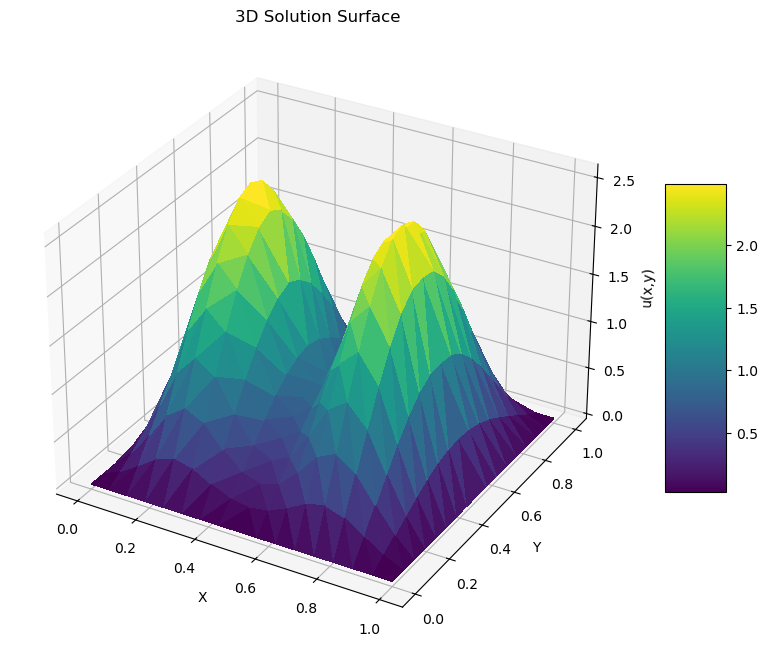

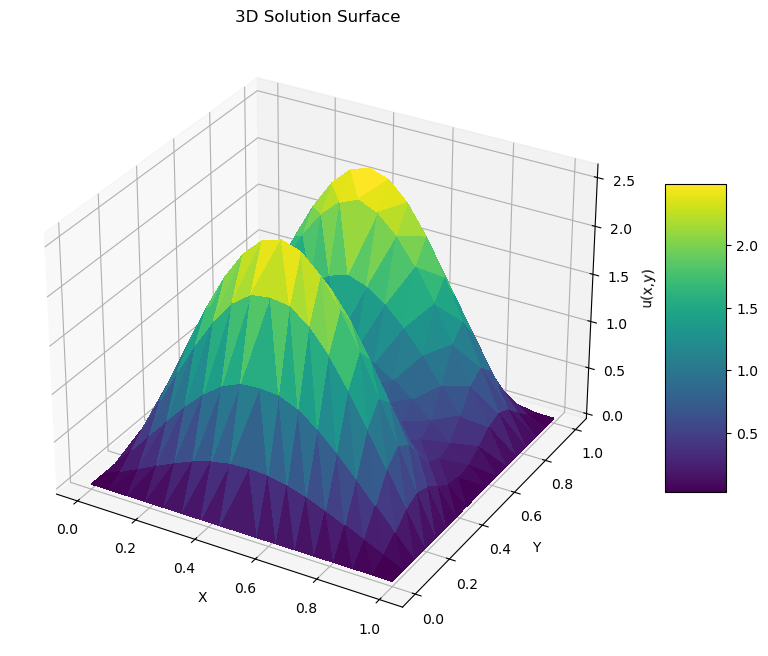

In [47]:
u1_result_interior,u2_result_interior = unpack(result)
femsystem.plot_at_interior_2d_in3d(u1_result_interior,plot_title="U1")
femsystem.plot_at_interior_2d_in3d(u2_result_interior,plot_title="U2")